<h1 align="center">Volume 4: Total Variation.</h1>

    Samuel Goldrup
    002
    23 February 2023

In [1]:
import numpy as np
import matplotlib
matplotlib.use('nbAgg')
from matplotlib import pyplot as plt

from numpy.random import randint, uniform, randn
import matplotlib.pyplot as plt
from matplotlib import cm
from imageio import imread, imwrite

# Problem 1

Using $20$ $x$ steps, $250$ time steps, $a=-1$, $b=1$, $\alpha = 1$, $\beta=7$, and a final time of $0.2$, plot the solution that minimizes (17.4). It should match figure 17.1.

Difference in iterations is  0.0
Final time =  0.2


<IPython.core.display.Javascript object>


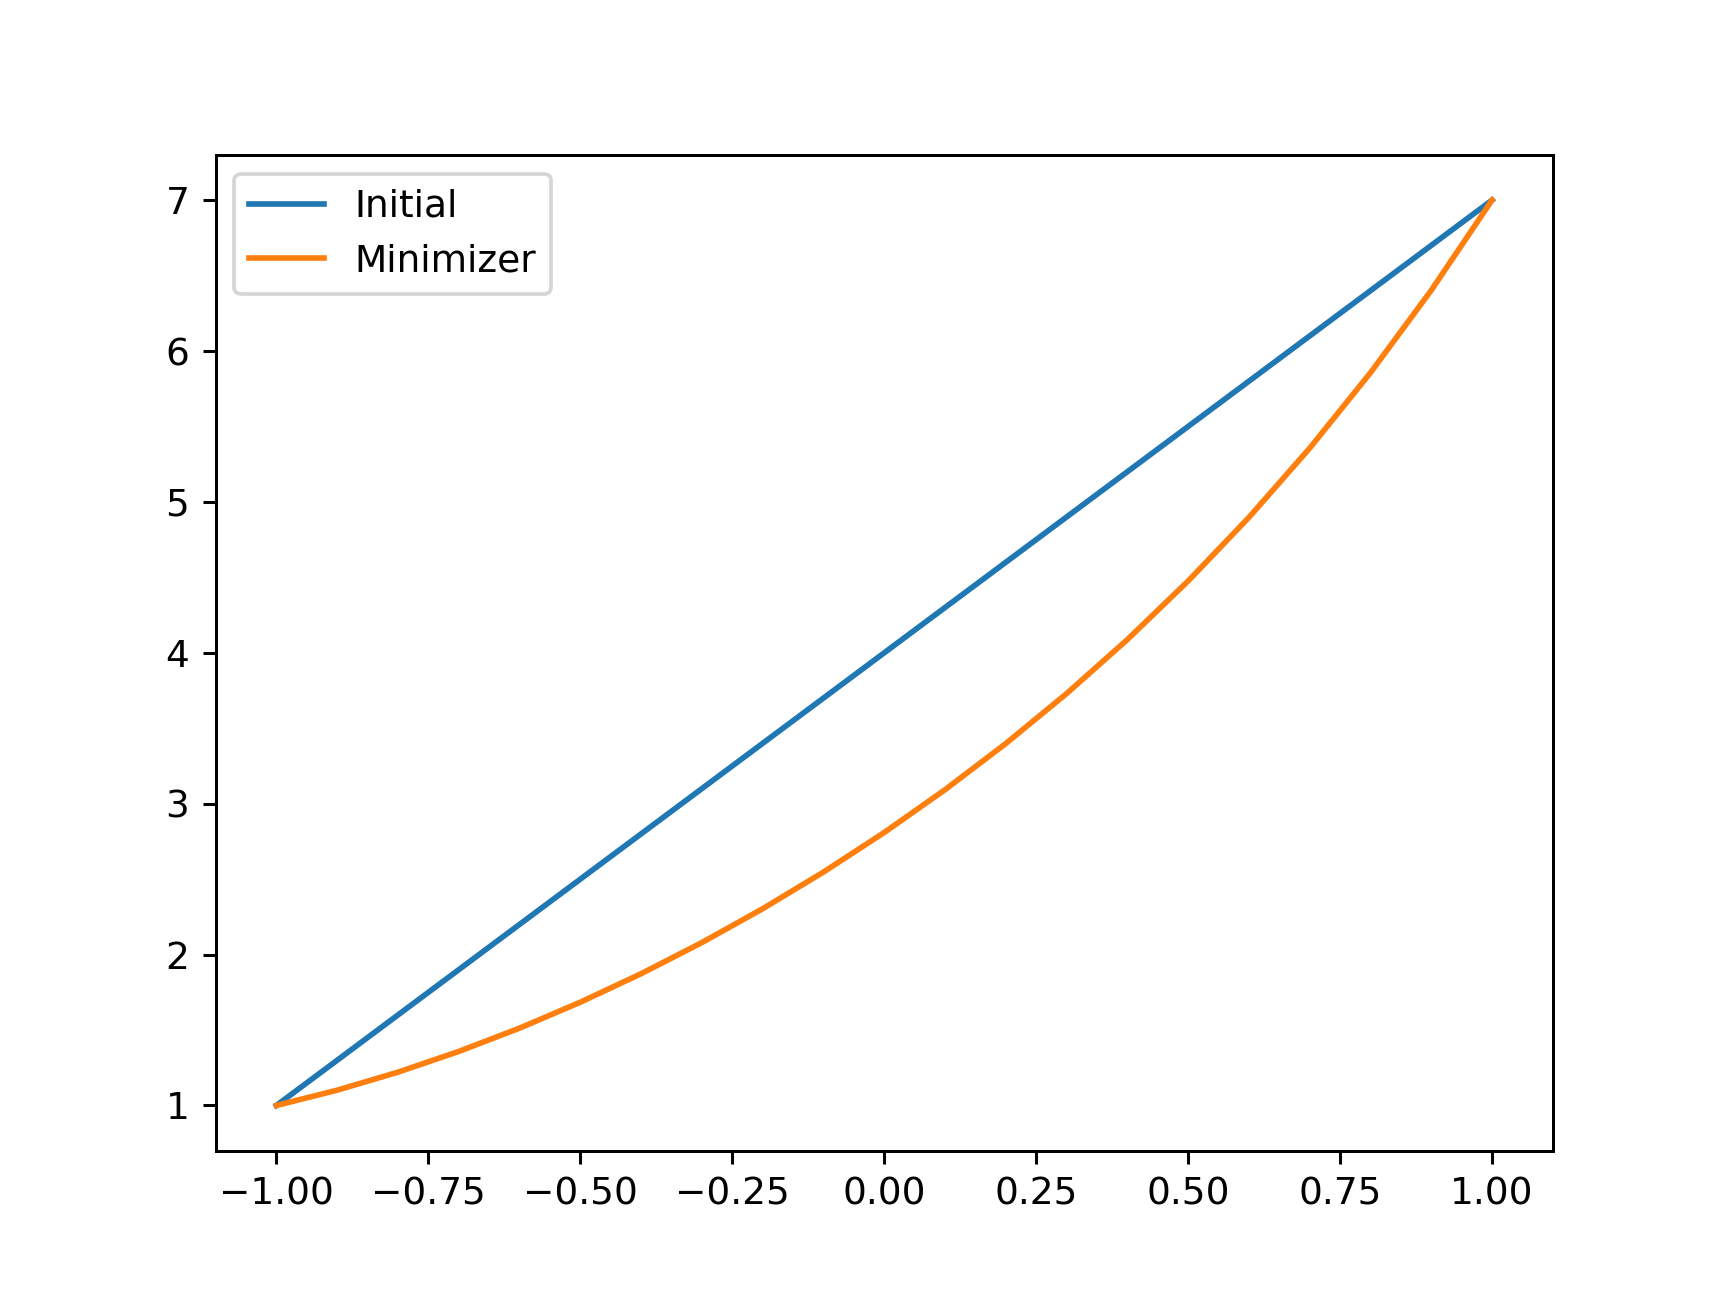

In [2]:
x_steps = 20
time_steps = 250
final_T = 0.2
a,b = -1,1.
alpha, beta = 1.,7.
delta_t, delta_x = final_T/time_steps, (b-a)/x_steps
x0 = np.linspace(a,b,x_steps+1)

if delta_t/delta_x**2. > 5.: #stability check
    print("stability criterion not met")
    
#precondition the solution
u = np.empty((2,x_steps+1))
u[0] = (beta - alpha)/(b-a)*(x0-a) + alpha
u[1] = (beta - alpha)/(b-a)*(x0-a) + alpha

init = u[0].copy() #save initial guess

def rhs(y): #right hand side
    #approximations of first, second order derivative
    yp = (np.roll(y,-1) - np.roll(y,1))/(2.*delta_x)
    ypp = (np.roll(y,-1) - 2.*y + np.roll(y,1))/delta_x**2.
    #find approximation for the next time step (first order euler time stepping)
    y[1:-1] -= delta_t*(1. + yp[1:-1]**2. - 1.*y[1:-1]*ypp[1:-1])

it_num = time_steps
for i in range(time_steps):
    rhs(u[1])
    if np.linalg.norm(np.abs((u[0] - u[1]))) < 1e-5: 
        it_num = i
        break
    u[0] = u[1]

print("Difference in iterations is ", np.linalg.norm(np.abs((u[0] - u[1]))))
print("Final time = ", it_num*delta_t)


x_space = np.linspace(-1,1,x_steps+1)

plt.plot(x_space,init,label="Initial")
plt.plot(x_space,u[1],label="Minimizer")
plt.legend()
plt.show()

# Problem 2

Using $\Delta t = 1e{-3},$ $\lambda = 40,$ $\Delta x = 1,$ and $\Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$. (So $\Omega = [0,n_x]\times [0,n_y]$, where $n_x$ and $n_y$ represent the number of pixels in the $x$ and $y$ dimensions, respectively.) Take 250 steps in time. Plot the original image as well as the image with noise. Compare your results with Figure 17.3.

C:\Users\sgold\AppData\Local\Temp/ipykernel_83340/3986295565.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  IM = imread(imagename, as_gray=True) * (1. / 255)
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


<IPython.core.display.Javascript object>


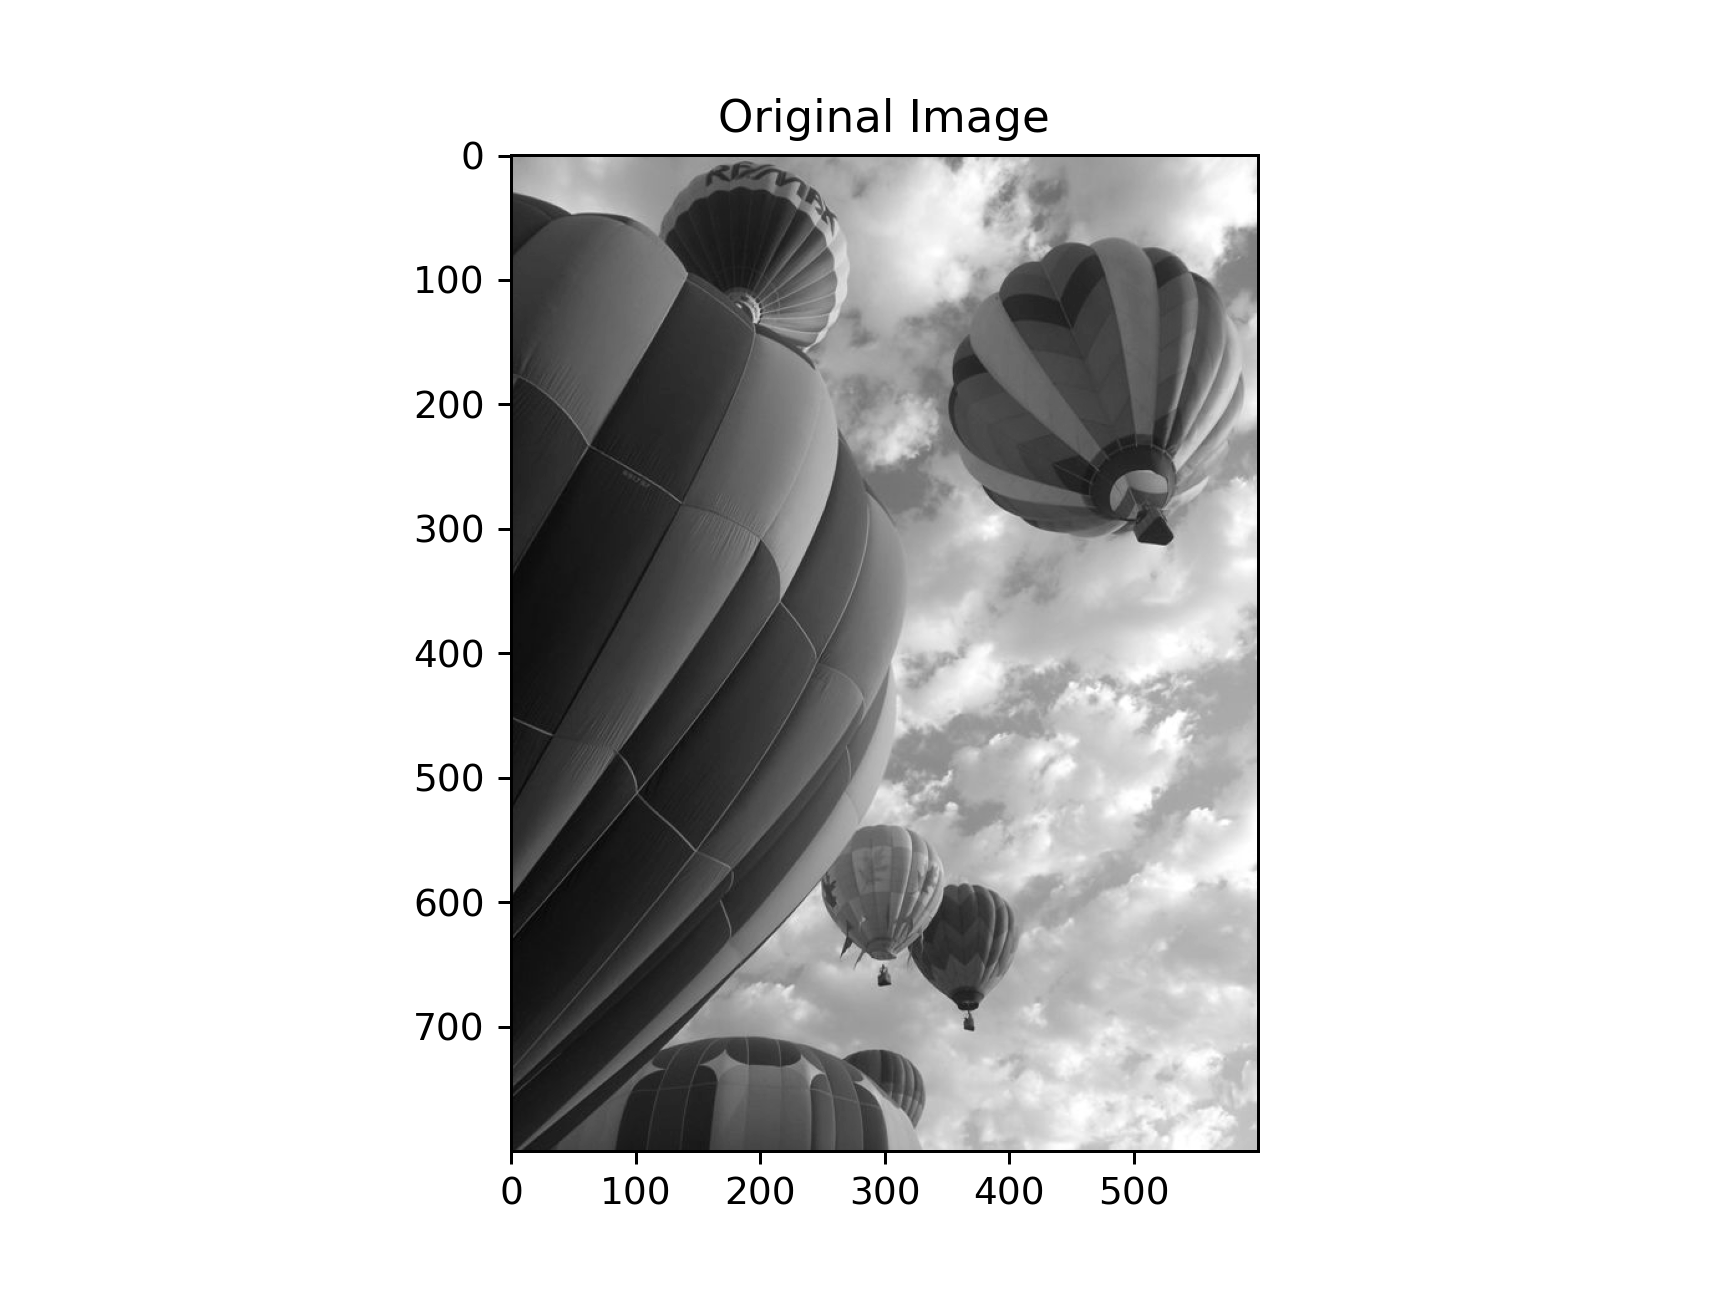

<IPython.core.display.Javascript object>


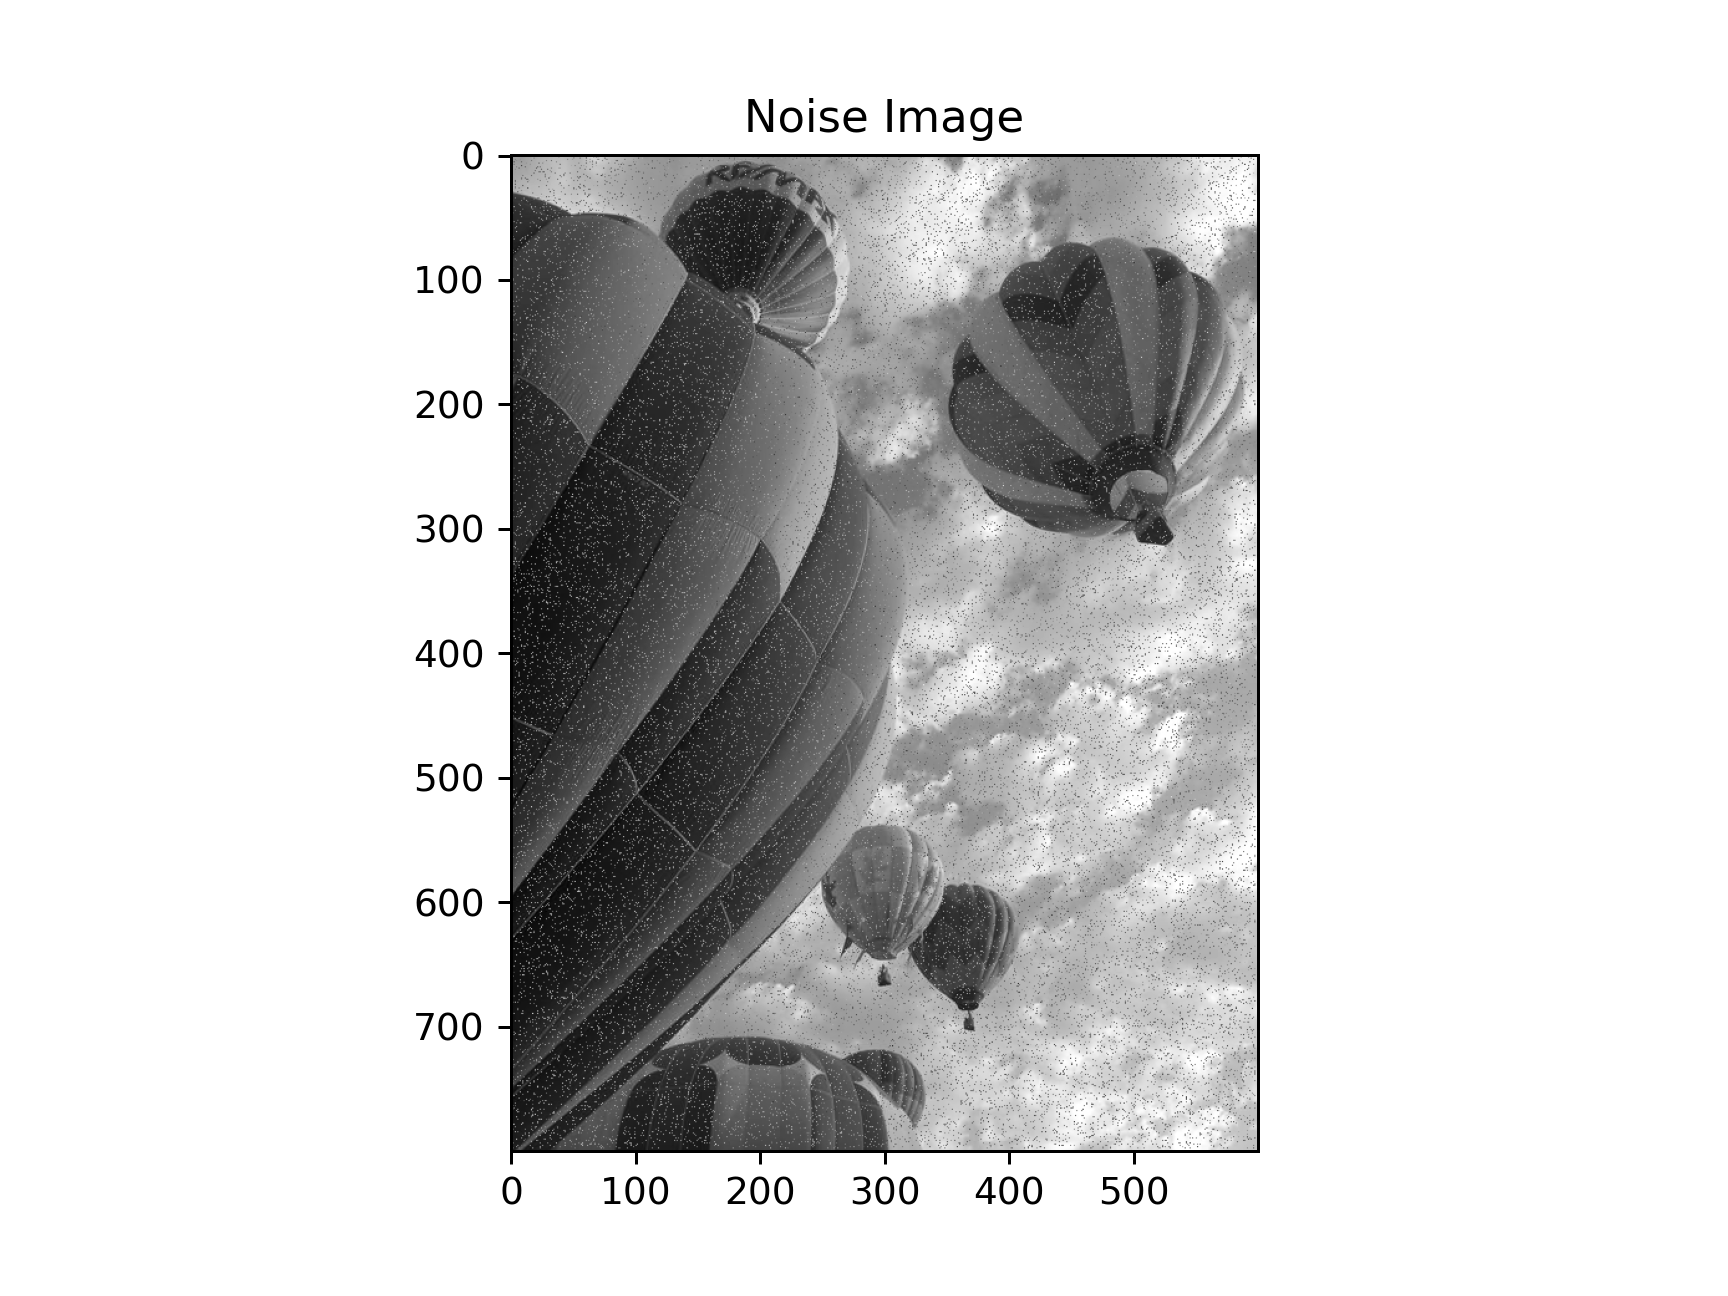

<IPython.core.display.Javascript object>


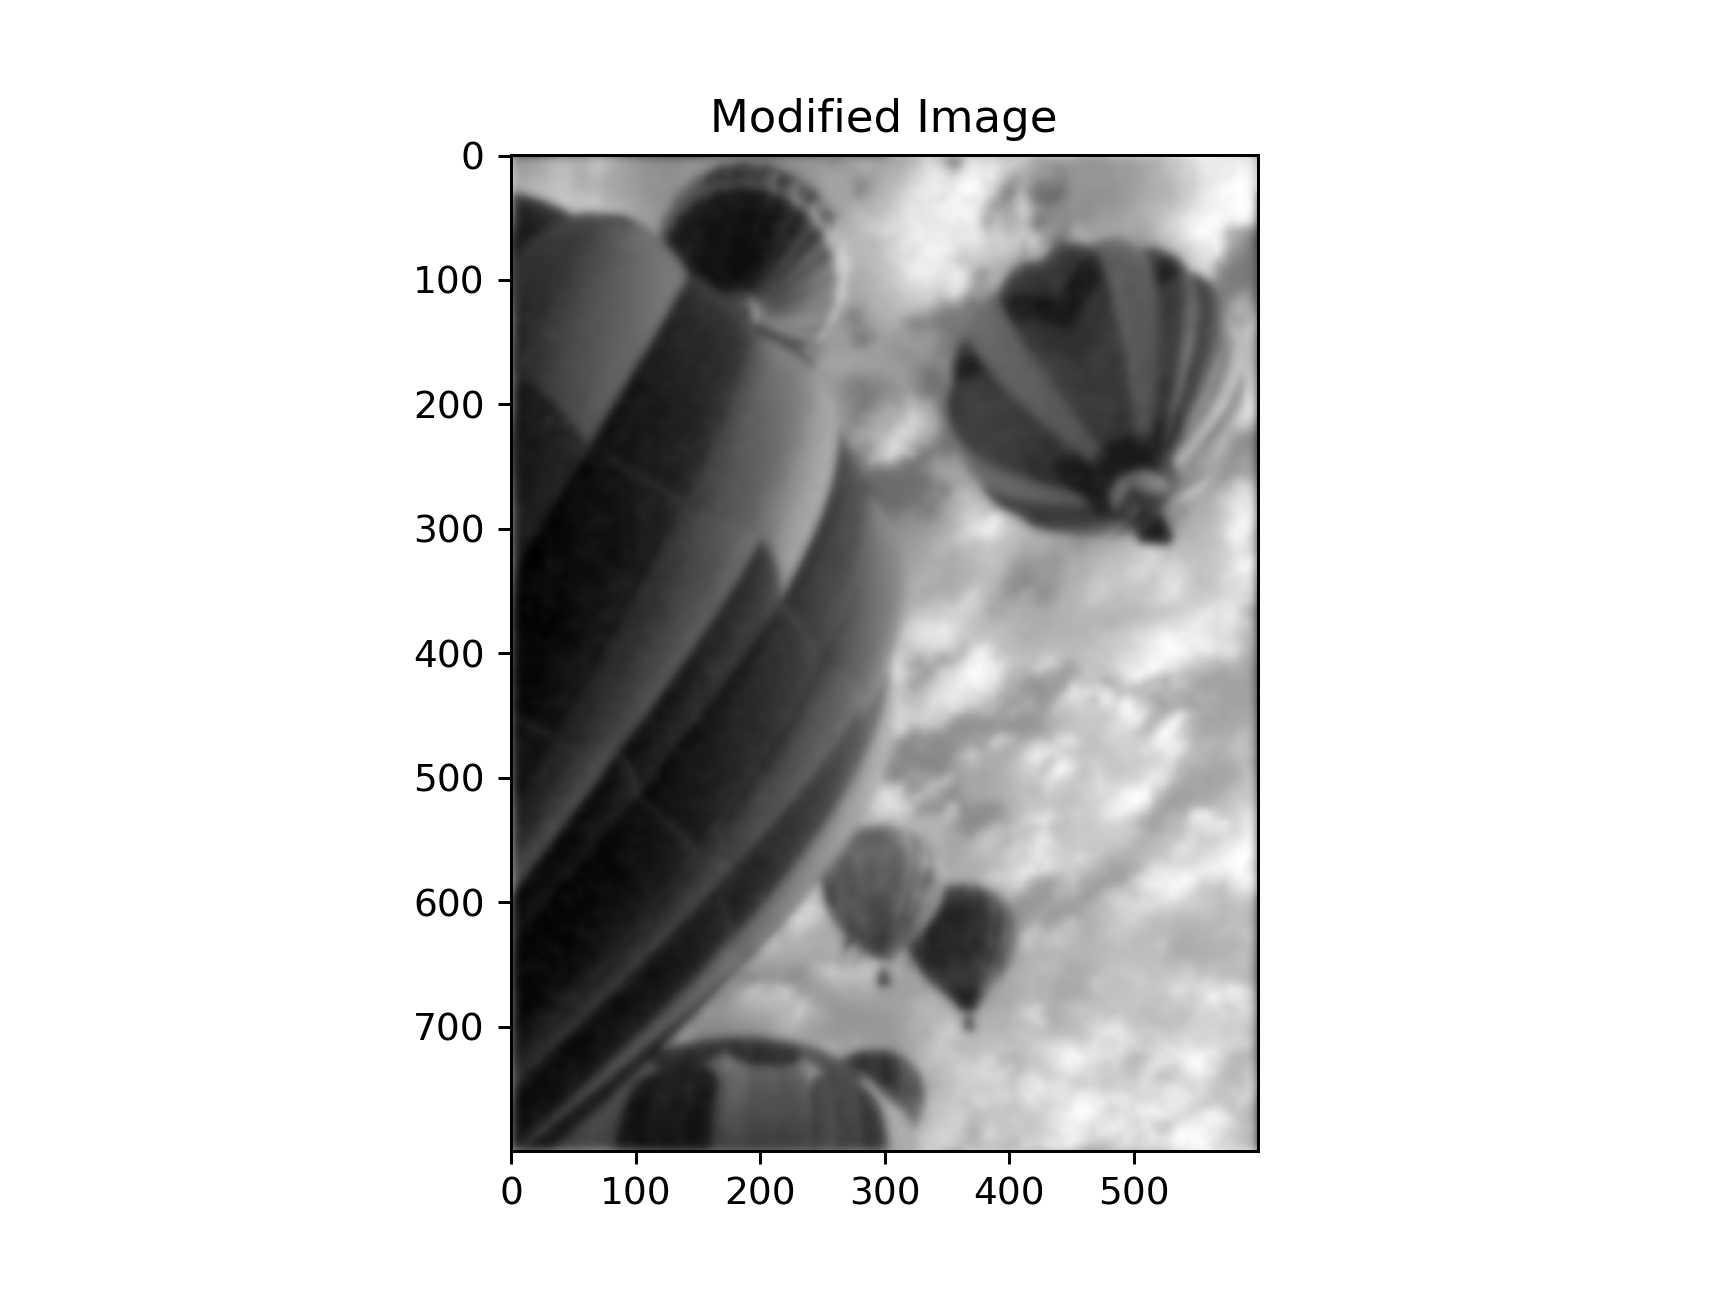

In [3]:
imagename = 'balloons_color.jpg'
changed_pixels=40000

IM = imread(imagename, as_gray=True) * (1. / 255)
IM_orig = IM.copy()
IM_x, IM_y = IM.shape

for lost in range(changed_pixels):
    x_,y_ = randint(1,IM_x-2), randint(1,IM_y-2)
    val = .1*randn() + .5
    IM[x_,y_] = max( min(val,1.), 0.)
    
imwrite("noised_"+imagename, IM)

f,u = np.copy(IM), np.copy(IM)

delta_t = 1e-03
lamb = 40
delta_x = 1
delta_y = 1
nx, ny = IM.shape
time_steps = 250

def rhs(ut):
    u_xx = np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1) #delta_x is 1
    u_yy = np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0) #delta_y is 1
    ut = ut + delta_t*(-ut+f+lamb*(u_xx+u_yy)) #update
    return ut
    
for i in range(time_steps):
    u_new = rhs(u)
    if np.linalg.norm(np.abs((u_new - u))) < 1e-5: 
        break
    u = u_new
    
    
plt.title("Original Image")
plt.imshow(IM_orig,cmap="gray")
plt.show()

plt.title("Noise Image")
plt.imshow(IM,cmap="gray")
plt.show()

plt.title("Modified Image")
plt.imshow(u,cmap="gray")
plt.show()

# Problem 3

Using $\Delta t = 1e-3, \lambda = 1, \Delta x = 1,$ and $ \Delta y = 1$, implement the numerical scheme mentioned above to obtain a solution $u$.  Take 200 steps in time. Display both the diffusion-based and total variaton images of the balloon. Compare your results with
Figure 17.3. How small should ε be?

<IPython.core.display.Javascript object>


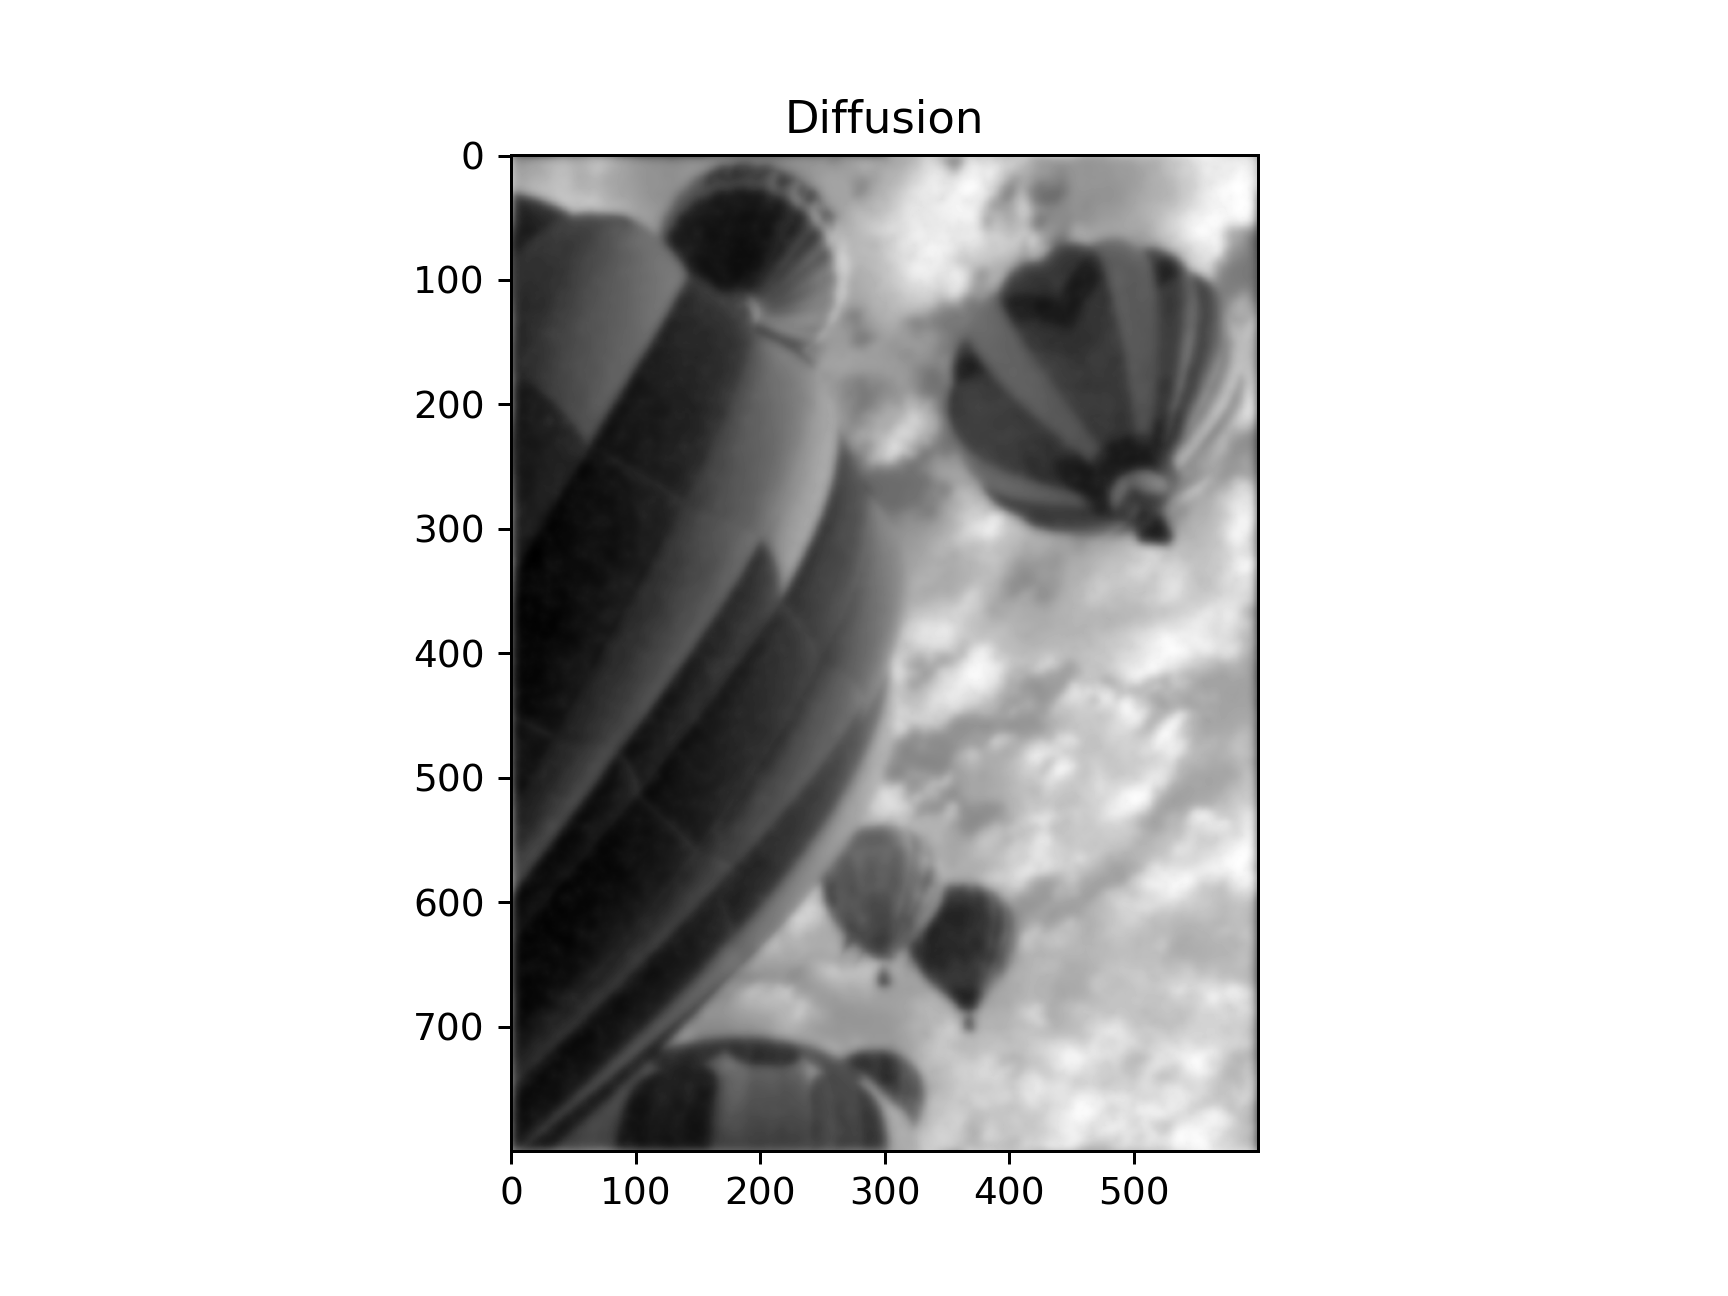

<IPython.core.display.Javascript object>


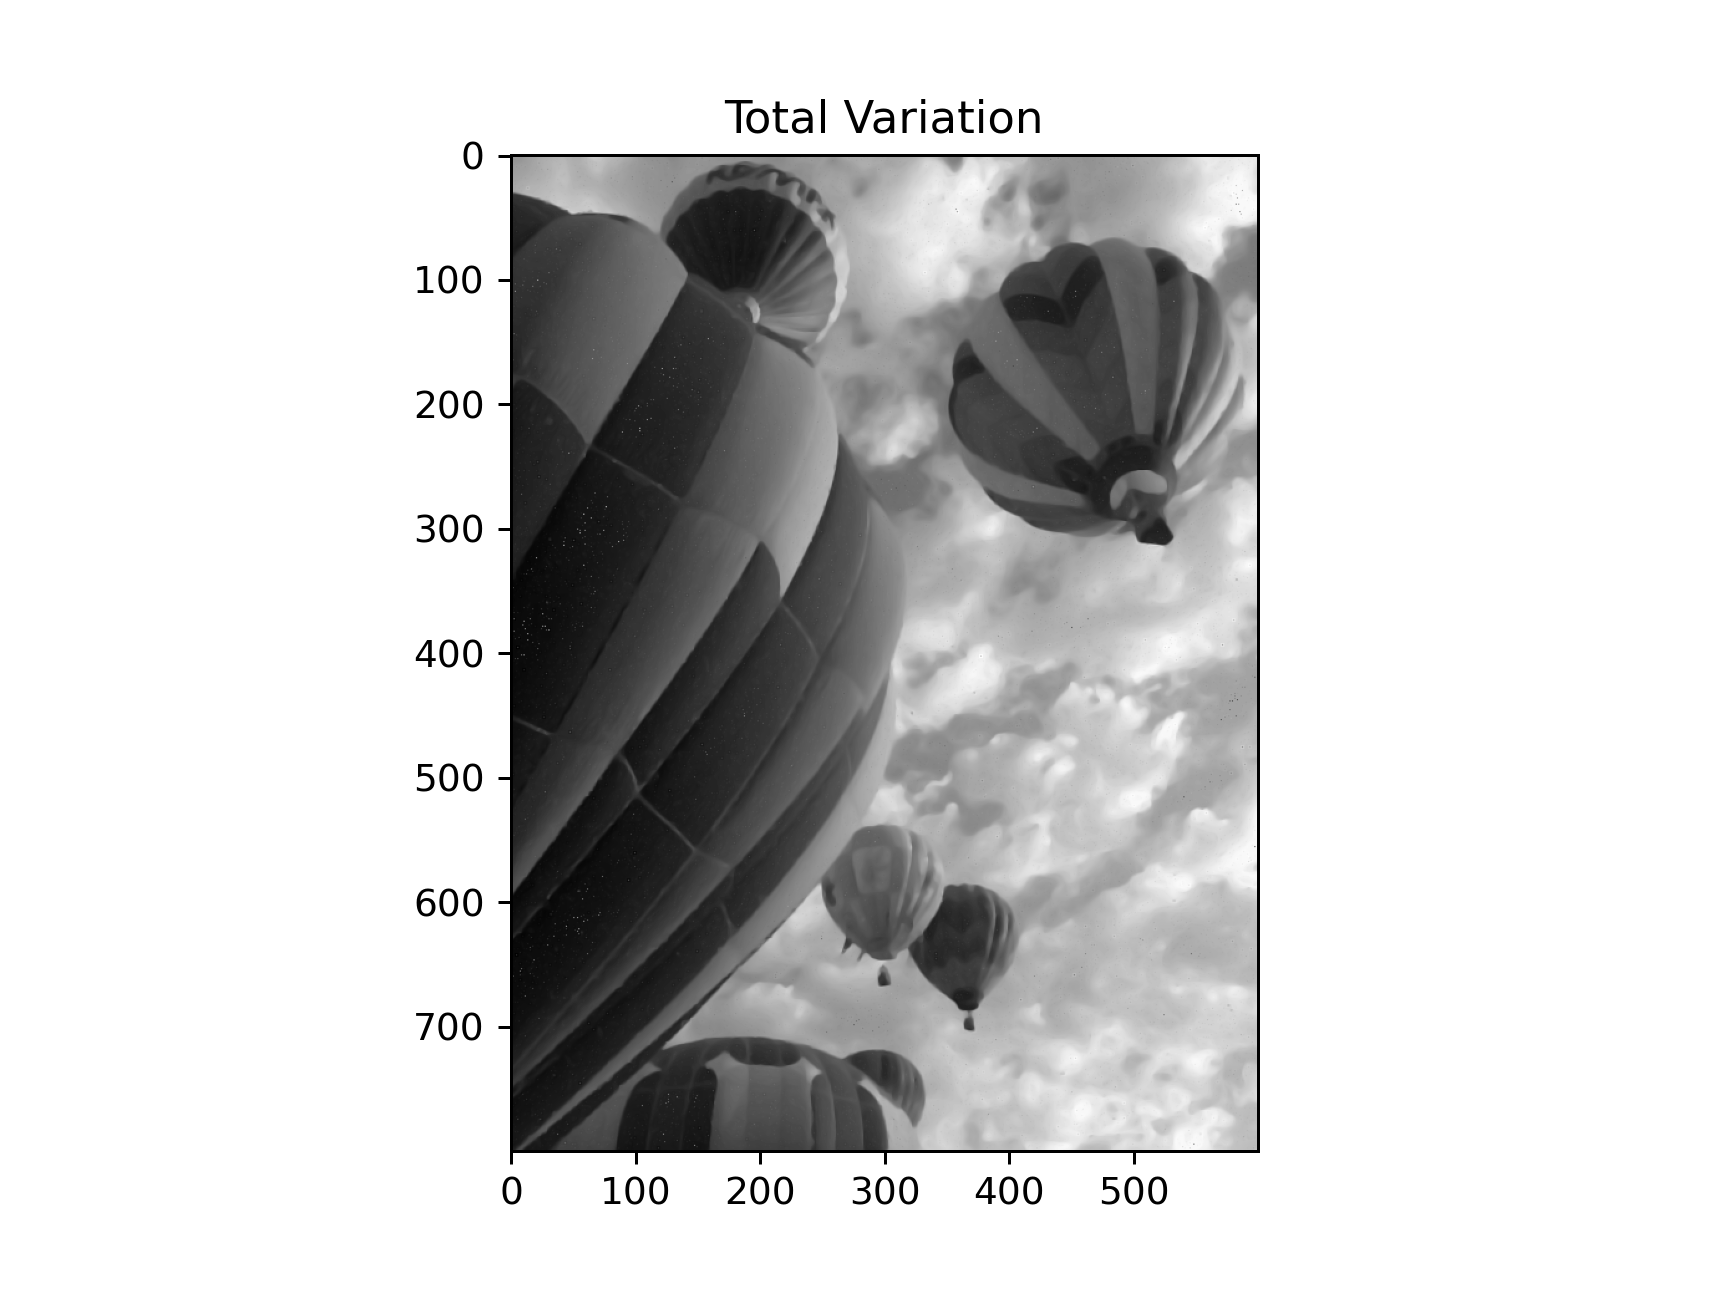

In [4]:
prob2 = np.copy(u) #save diffusion solution
u = np.copy(IM) #get the image, reset the problem

delta_t = 1e-03
lamb = 1
delta_x = 1
delta_y = 1
time_steps = 200

def rhs(ut):
    u_x = (np.roll(u,-1,axis=1) - np.roll(u,1,axis=1))/2
    u_y = (np.roll(u,-1,axis=0) - np.roll(u,1,axis=0))/2
    
    u_xx = np.roll(u,-1,axis=1) - 2*u + np.roll(u,1,axis=1)
    u_yy = np.roll(u,-1,axis=0) - 2*u + np.roll(u,1,axis=0)
    
    u_xy = (np.roll(u_x,-1,axis=0) - np.roll(u_x,1,axis=0))/2.
    
    numer = u_xx*u_y**2 + u_yy*u_x**2 - 2*u_x*u_y*u_xy
    denom = (1e-4 + u_x**2. + u_y**2.)**(3/2) #add 1e-04 to denominator for numerical purposes
    ut = ut + delta_t*(-lamb*(ut-f) + numer/denom) #update
    return ut

for i in range(time_steps):
    u_new = rhs(u)
    if np.linalg.norm(np.abs((u - u_new))) < 1e-5: 
        break
    u = u_new
    
plt.title("Diffusion")
plt.imshow(prob2,cmap="gray")
plt.show()

plt.title("Total Variation")
plt.imshow(u,cmap="gray")
plt.show()

0.0001 is a good value for epsilon